In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import typing as tp
from copy import deepcopy

import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import minimize
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.svm import SVC

GLOBAL_RANDOM_STATE = 42

# Домашнее задание №2. SVM.

Нужно реализовать несколько алгоритмов SVM с помощью numpy/scipy библиотек. Каждую из реализаций сравнить с соответсвующей sklearn реализацией SVM алгоритма. 

## Задание №1 (15 баллов)

Реализовать класс **LinearPrimalSVM** - метод решения **много-классового линейного метода опорных векторов в стандартной задаче  оптимизации с квадратичной регуляризацией**. Для обучения много-классового алгоритма воспользоваться схемой **one-vs-rest**.  Реализовать методы init, fit, predict c возможностью конфигурации параметра регуляризации. Остальные функции реализовать на ваше усмотрение. 

Для оптимизации функции ошибки воспользоваться методом **стохастического градиентного спуска**.

$$
L_{w,b}( x_{i} ,y_{i}) =\frac{1}{N}\sum _{i=1}^{N}\max\left( 0,1-y_{i}\left( x_{i}^{T} w+b\right)\right) +\frac{1}{2C} ||w||^{2} \\
\nabla _{w} L_{w,b}( x_{i} ,y_{i}) =\frac{w}{C} +\frac{1}{N}\sum _{i=1}^{N} -y_{i} x_{i} \cdotp \mathbb{I}\left[ 1-y_{i}\left( x_{i}^{T} w+b\right)  >0\right] \\
\nabla _{b} L_{w,b}( x_{i} ,y_{i}) =\frac{1}{N}\sum _{i=1}^{N} -y_{i} \cdotp \mathbb{I}\left[ 1-y_{i}\left( x_{i}^{T} w+b\right)  >0\right]
$$

In [3]:
class BinaryLinearPrimalSVM:
    def __init__(
        self,
        fit_intercept: bool = True,
        C: float = 1.0,
        random_state: int = None,
        lr: float = 1e-3,
        batch_size: int = 32,
        tol: float = 1e-6,
        max_iter: int = 500,
        warm_start: bool = False,
        metrics: tp.Callable = accuracy_score,
        momentum: float = 0.999,
        lr_decay: float = None,
        lr_decay_freq=None,
    ):
        self.fit_intercept = fit_intercept
        self.C = C
        self.fitted = False
        self.oh = OneHotEncoder(sparse=False, handle_unknown="ignore")
        self.loss_history = []
        self.val_loss = []
        self.score_hist = []
        self.metrics = metrics
        self.lr = lr
        self.tol = tol
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.warm_start = warm_start
        self.random_state = random_state
        self.momentum = momentum
        self.lr_decay = 1.0 if lr_decay is None else lr_decay
        self.lr_decay_freq = [] if lr_decay_freq is None else lr_decay_freq
        if type(lr_decay_freq) == int:
            self.lr_decay_freq = np.arange(0, self.max_iter, lr_decay_freq)
        
        self.w = None
        self.b = None

    def _init_weights(self) -> tp.Tuple[tp.Any]:
        stdv = 1.0 / np.sqrt(self.n_features)
        distr = sps.uniform(loc=-stdv, scale=2 * stdv)
        rvs = distr.rvs(size=self.n_features + 1, random_state=self.random_state)
        return rvs[:-1], rvs[-1]

    def _get_logits(self, X_batch: np.array) -> float:
        logits = np.zeros(X_batch.shape[0])
        np.dot(X_batch, self.w, out=logits)
        logits += self.b
        return logits

    def _hinge(self, X_batch: np.array, Y_batch: np.array) -> np.array:
        result = self._get_logits(X_batch)
        np.multiply(Y_batch, result, out=result)
        np.subtract(1.0, result, out=result)
        return result

    def _get_indicator(self, X_batch: np.array, Y_batch: np.array) -> np.array:
        N = X_batch.shape[0]
        indicator = np.zeros(N)
        np.greater(self._hinge(X_batch, Y_batch), 0, out=indicator)
        np.multiply(Y_batch, indicator, out=indicator)
        np.multiply(-1.0, indicator, out=indicator)
        return indicator

    def _grad_loss(self, X_batch: np.array, Y_batch: np.array) -> tp.Tuple[tp.Any]:
        indicator = self._get_indicator(X_batch, Y_batch)
        updated_batch = np.zeros_like(X_batch)
        np.multiply(X_batch, indicator.reshape((-1, 1)), out=updated_batch)
        mean = np.zeros(self.n_features, dtype=np.float32)
        np.mean(updated_batch, axis=0, out=mean)
        w = self.w / self.C
        return mean + w, np.mean(indicator)

    def _loss(self, X_batch: np.array, Y_batch: np.array) -> float:
        regul = np.sum(np.square(self.w)) / (2 * self.C)
        maximum = np.zeros(X_batch.shape[0], dtype=np.float32)
        np.maximum(self._hinge(X_batch, Y_batch), 0, out=maximum)
        return np.mean(maximum) + regul

    def _get_batch(self, X_train: np.array, Y_train: np.array):
        n_samples = X_train.shape[0]
        indices = np.arange(n_samples)
        rs = np.random.RandomState(self.random_state)
        rs.shuffle(indices)
        for start in range(0, n_samples, self.batch_size):
            end = min(start + self.batch_size, n_samples)
            batch_idx = indices[start:end]
            yield X_train[batch_idx], Y_train[batch_idx]
    
    def _logits_to_sign(self, logits: np.array) -> np.array:
        signs = np.zeros_like(logits)
        np.greater(logits, 0.0, out=signs)
        return signs

    def _SGD(
        self, X_train: np.array, Y_train: np.array, X_val: np.array, Y_val: np.array
    ):
        old_grad = np.zeros_like(a=self.w)
        old_grad_b = 0.0
        best_val_loss = np.inf
        step = 0
        epoch_num = 1
        to_stop = False
        while not to_stop:
            for X_batch, Y_batch in self._get_batch(X_train, Y_train):
                curr_lr = self.lr
                if step in self.lr_decay_freq:
                    curr_lr /= 1 + (self.lr_decay * epoch_num)

                train_loss = self._loss(X_batch, Y_batch)
                val_loss = self._loss(X_val, Y_val)
                curr_preds = self._logits_to_sign(self._get_logits(X_val))
                score = self.metrics(curr_preds, Y_val)
                self.loss_history.append(train_loss)
                self.val_loss.append(val_loss)
                self.score_hist.append(score)

                # check stopping criteria
                if step >= self.max_iter or (
                    step >= 1 and best_val_loss - val_loss <= self.tol
                ):
                    to_stop = True
                    break

                if val_loss < best_val_loss:
                    best_val_loss = val_loss

                gradW, gradB = self._grad_loss(X_batch, Y_batch)
                np.add(
                    self.momentum * old_grad,
                    curr_lr * gradW,
                    out=old_grad,
                )
                np.subtract(self.w, old_grad, out=self.w)
                if self.fit_intercept:
                    old_grad_b = self.momentum * old_grad_b + curr_lr * gradB
                    self.b -= old_grad_b
                step += 1
            epoch_num += 1
        if step == self.max_iter:
            print(f"WARNING: SGD didn't converge in {step} steps.")

    def fit(self, X: np.array, Y: np.array) -> "BinaryLinearPrimalSVM":
        X = np.array(X)
        Y = np.array(Y)
        self.n_features = X.shape[1]
        # convert 1 and 0 array to 1 and -1 array
        X_train, X_val, Y_train, Y_val = train_test_split(
            X, Y, test_size=0.1, random_state=self.random_state
        )
        Y_train *= 2
        np.subtract(Y_train, np.ones_like(Y_train), out=Y_train)
        # print(np.unique(Y_val, return_counts=True))

        if not self.warm_start:
            self.w, self.b = self._init_weights()
            if not self.fit_intercept:
                self.b *= 0.0
            self.loss_history.clear()
            self.score_hist.clear()
            self.val_loss.clear()

        self._SGD(X_train, Y_train, X_val, Y_val)
        self.fitted = True
        return self

    def predict(self, X_test: np.array) -> np.array:
        X_test = np.array(X_test)
        if not self.fitted:
            print("WARNING: Predicting without fitting, behaviour is undefined.")
            return np.zeros(shape=X_test.shape[0], dtype=np.int32)
        return self._logits_to_sign(self._get_logits(X_test))
    
    def decision_function(self, X: np.array) -> np.array:
        return self._get_logits(X)


class LinearPrimalSVM:
    def __init__(
        self,
        fit_intercept: bool = True,
        C: float = 1.0,
        random_state: int = None,
        lr: float = 1e-3,
        batch_size: int = 32,
        tol: float = 1e-6,
        max_iter: int = 500,
        warm_start: bool = False,
        metrics: tp.Callable = accuracy_score,
        momentum: float = 0.999,
        lr_decay: float = None,
        lr_decay_freq=None,
    ):
        self.base_model = BinaryLinearPrimalSVM(
            fit_intercept=fit_intercept,
            C=C,
            random_state=random_state,
            lr=lr,
            batch_size=batch_size,
            tol=tol,
            warm_start=warm_start,
            max_iter=max_iter,
            metrics=metrics,
            momentum=momentum,
            lr_decay=lr_decay,
            lr_decay_freq=lr_decay_freq,
        )
        self.models = []
        self.oh = OneHotEncoder(sparse=False)
        self.fitted = False

    def fit(self, X: np.array, Y: np.array):
        """функция обучения модели"""
        X = np.array(X)
        Y = np.array(Y)
        Y = self.oh.fit_transform(Y.reshape((-1, 1)))
        self.n_classes = Y.shape[1]

        for _ in range(self.n_classes):
            self.models.append(deepcopy(self.base_model))
        
        for i in range(self.n_classes):
            self.models[i].fit(X, Y[:, i])
        
        self.fitted = True

    def predict(self, X_test):
        """функция предсказания"""
        X_test = np.array(X_test)
        preds = []
        for model in self.models:
            preds.append(model.decision_function(X_test))
        preds = np.array(preds).T
        return np.argmax(preds, axis=1)
    
    def get_coef(self) -> np.array:
        weights = []
        for m in self.models:
            weights.append(m.w)
        return np.array(weights)
    
    def get_intercept(self) -> np.array:
        b = []
        for m in self.models:
            b.append(m.b)
        return np.array(b)

Оцените ваш алгоритм на тестовом сплите многоклассовом датасете классификации по выбранной метрике качества. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) или сгенерировать самому. Сравните ваш алгоритм с sklearn имплементацией со следующими парарметрами:

[*_sklearn.linear_model.SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True)_*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

Остальные параметры алгоритма на ваше усмотрение. 

Отличие в метриках между вашим алгоритмом и sklearn имплементацией алгоритма. Отличие в качестве не должно составлять более **1-2%**.

In [4]:
X, y = make_blobs(n_features=2, n_samples=2000, cluster_std=3.0, random_state=GLOBAL_RANDOM_STATE)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, train_size=0.80, test_size=0.20, random_state=GLOBAL_RANDOM_STATE
)
X_train.shape, X_test.shape, Y_train.shape

((1600, 2), (400, 2), (1600,))

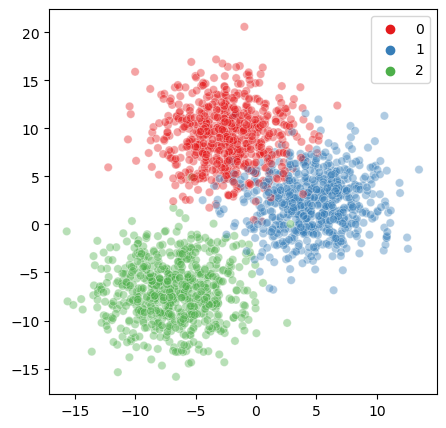

In [5]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=sns.color_palette("Set1"), alpha=0.4)
plt.show()

In [6]:
std_scaler = StandardScaler()
X_train_tr = std_scaler.fit_transform(X_train)
X_test_tr = std_scaler.transform(X_test)

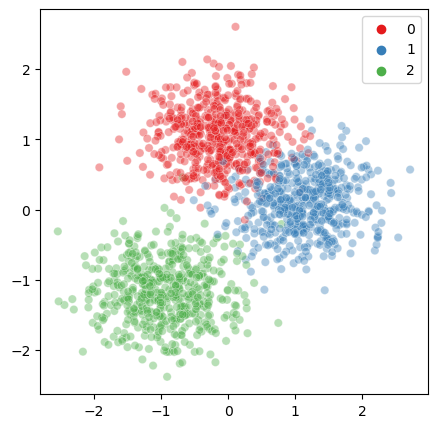

In [7]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_train_tr[:, 0], y=X_train_tr[:, 1], hue=Y_train, palette=sns.color_palette("Set1"), alpha=0.4)
plt.show()

In [8]:
gold_model = SGDClassifier(
    loss="hinge",
    penalty="l2",
    random_state=GLOBAL_RANDOM_STATE,
)
gold_model.fit(X_train_tr, Y_train)
gold_preds = gold_model.predict(X_test_tr)
gold_scores = f1_score(gold_preds, Y_test, average="macro"), accuracy_score(gold_preds, Y_test)
print(gold_scores)

(0.9489168051826281, 0.95)


In [9]:
model = LinearPrimalSVM(
    C=5.0,
    lr=5.0,
    max_iter=1000,
    lr_decay=2.5,
    lr_decay_freq=1,
    random_state=GLOBAL_RANDOM_STATE,
    batch_size=512,
    momentum=0.0,
    tol=1e-6,
    metrics=f1_score,
)
model.fit(X_train_tr, Y_train)
preds = model.predict(X_test_tr)
scores = f1_score(preds, Y_test, average="macro"), accuracy_score(preds, Y_test)
print(scores)
Y_test_oh = model.oh.transform(Y_test.reshape((-1, 1)))

(0.941428004508151, 0.9425)


### Задание № 2 (10 баллов)

Визуализируйте построенные разделяющие прямые на вашем мультиклассовом датасете. Для визуализации можно пользоваться любыми библиотеками визуализации. В конце ноутбука приведены вспомогательные функции для визуализации.

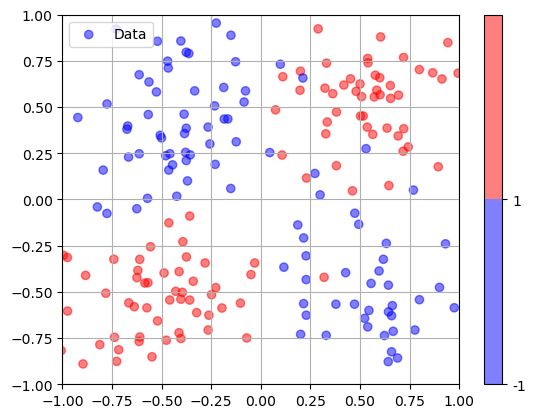

In [10]:
import matplotlib.colors as pltcolors

def plot_line(ax, x_range, w, x0, label, color="grey", linestyle="-", alpha=1.0):
    """График разделяющей прямой с помощью вектора весов w и смещения x0"""
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (x_range - x0[0]) + x0[1]
    ax.plot(x_range, yy, color=color, label=label, linestyle=linestyle)


def plot_svm(
    X,
    y,
    support=None,
    w=None,
    intercept=0.0,
    label="Data",
    separatorLabel="Separator",
    ax=None,
    bound=[[-1.0, 1.0], [-1.0, 1.0]],
):
    """График SVM оптимальной разделяющей прямой c отображением опорных векторов support
    вектора весов w и смещения intercept"""
    if ax is None:
        fig, ax = plt.subplots(1)

    im = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(
            support[:, 0],
            support[:, 1],
            label="Support",
            s=80,
            facecolors="none",
            edgecolors="y",
            color="y",
        )
        print("Количество опорных векторов = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plot_line(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signed_dist = np.matmul(support, w)
            margin = np.max(signed_dist) - np.min(signed_dist) * np.sqrt(np.dot(w, w))
            support_max_neg = support[np.argmin(signed_dist)]
            plot_line(ax, xx, w, support_max_neg, "Margin -", linestyle="-.", alpha=0.8)
            support_max_pos = support[np.argmax(signed_dist)]
            plot_line(ax, xx, w, support_max_pos, "Margin +", linestyle="--", alpha=0.8)
            ax.set_title("Margin = %.3f" % (margin))
    ax.legend(loc="upper left")
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1, 1, 1)
    cb.set_ticks(loc)
    cb.set_ticklabels(["-1", "1"])


def generate_batch_xor(n, mu=0.5, sigma=0.5):
    """гауссианы в форме XOR операции"""
    X = np.random.normal(mu, sigma, (n, 2))
    yB0 = np.random.uniform(0, 1, n) > 0.5
    yB1 = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y0 = 2.0 * yB0 - 1
    y1 = 2.0 * yB1 - 1
    X[:, 0] *= y0
    X[:, 1] *= y1
    X -= X.mean(axis=0)
    return X, y0 * y1


colors = ["blue", "red"]
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100
xTrain3, yTrain3 = generate_batch_xor(2 * N, sigma=0.25)
plot_svm(xTrain3, yTrain3)
xTest3, yTest3 = generate_batch_xor(2 * N, sigma=0.25)

In [11]:
Y_train_oh = model.oh.transform(Y_train.reshape((-1, 1)))
Y_test_oh = model.oh.transform(Y_test.reshape((-1, 1)))

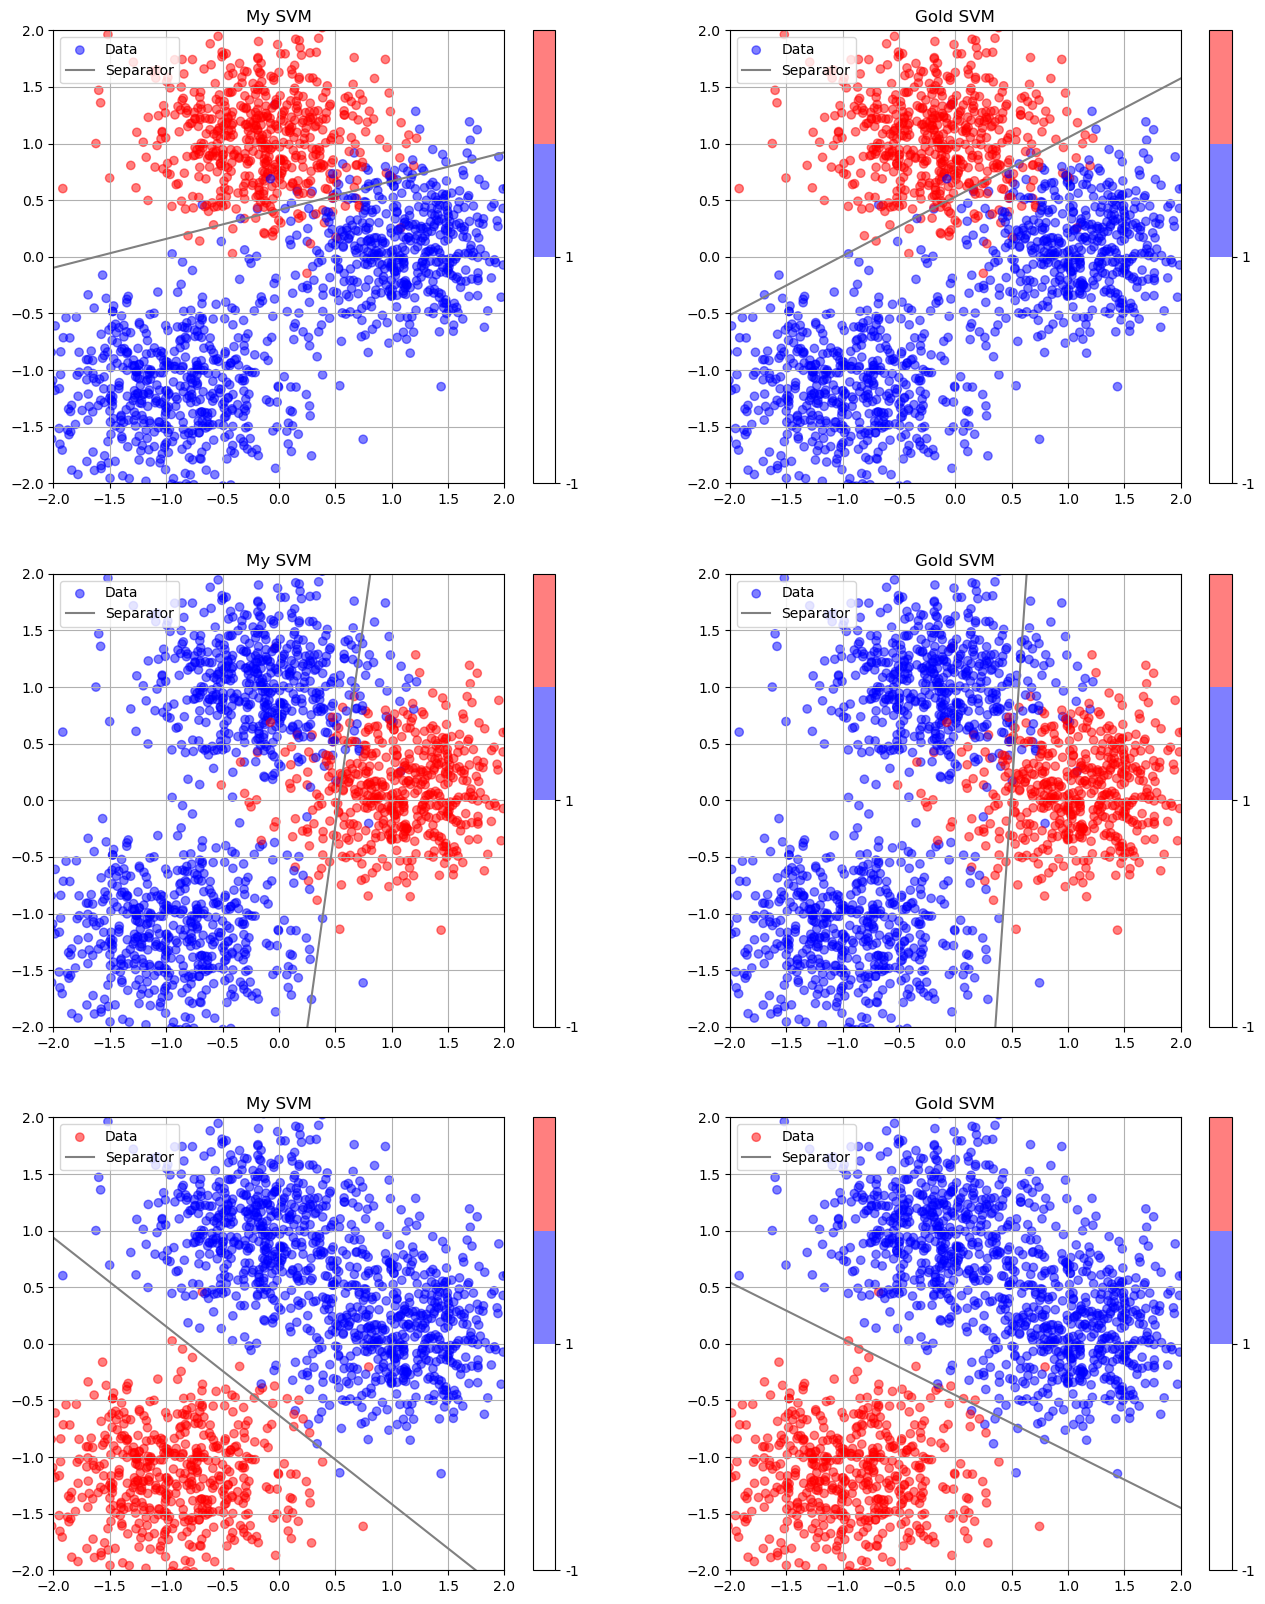

In [12]:
w = model.get_coef()
bias = model.get_intercept()

gold_w = gold_model.coef_
gold_bias = gold_model.intercept_

weight_pair = zip(w, gold_w)
bias_pair = list(zip(bias, gold_bias))
titles = ["My SVM", "Gold SVM"]

fig, axes = plt.subplots(3, 2, figsize=(16, 20))
for i in range(3):
    w_pair = (w[i], gold_w[i])
    for j in [0, 1]:
        plot_svm(ax=axes[i, j], X=X_train_tr, y=Y_train_oh[:, i], w=w_pair[j], intercept=bias_pair[i][j], bound=[[-2, 2], [-2, 2]])
        axes[i, j].set_title(titles[j])
plt.show()

In [13]:
# ! pip install mlxtend

In [14]:
from mlxtend.plotting import plot_decision_regions
from matplotlib.gridspec import GridSpec
import itertools

def plot_difference(clf0, gold_clf, X, y):
    gs = GridSpec(1, 2)

    fig = plt.figure(figsize=(12, 5))

    labels = ["My SVM", "Gold SVM"]
    clfs = [clf0, gold_clf]

    for clf, label, grid in zip(clfs, labels, itertools.product([0, 1], repeat=2)):
        ax = plt.subplot(gs[grid[0], grid[1]])
        fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
        plt.title(label)

    plt.show()

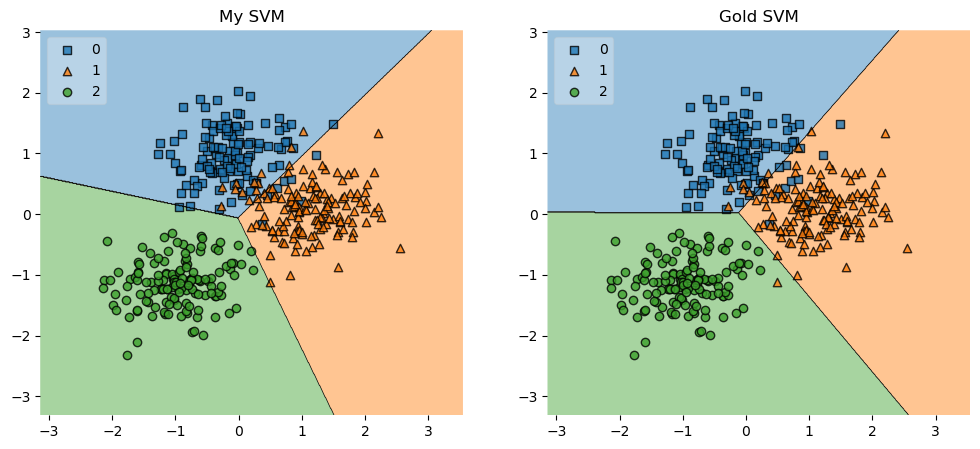

In [15]:
plot_difference(model, gold_model, X=X_test_tr, y=Y_test)

Постройте график зависимости качества вашего алгоритма от параметра регуляризации на тестовом сплите. 

In [16]:
C_arr = [1e-5, 1e-3, 1e-2, 0.5, 0.1, 0.5, 1.0, 10.0, 100.0, 500.0, 1000.0, 1e5]
scores = []
for C in C_arr:
    clf = LinearPrimalSVM(
        C=C,
        lr=5.0,
        max_iter=1000,
        lr_decay=2.5,
        lr_decay_freq=1,
        random_state=GLOBAL_RANDOM_STATE,
        batch_size=64,
        momentum=0.0,
        tol=1e-6,
        metrics=f1_score,
    )
    clf.fit(X_train_tr, Y_train)
    preds = clf.predict(X_test_tr)
    score = f1_score(preds, Y_test, average="macro")
    scores.append(score)

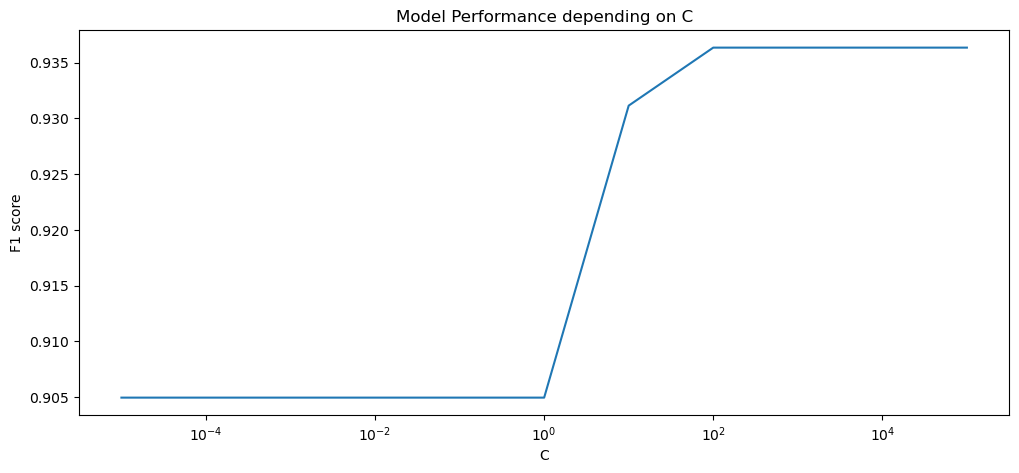

In [17]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=C_arr, y=scores)
plt.xlabel("C")
plt.ylabel("F1 score")
plt.xscale("log")
plt.title("Model Performance depending on C")
plt.show()

### Задание №3 (10 баллов)

Реализовать **NonlinearDualSVM** - метод решения **много-классового нелинейного метода опорных векторов двойственной задаче  оптимизации с квадратичной регуляризацией с поддежкой любого нелинейного ядра**. Алгоритм решения SVM через двойственную задачу можно взять из ноутбука, который мы рассматривали в классе - вам нужно поддержать многоклассовое решение задачи и поддержку ядра для решений в нелинейном случае. 

Для обучения много-классового алгоритма воспользоваться схемой **one-vs-one**. В качестве нелинейного ядра можно взять любое нелинейное [отсюда](https://scikit-learn.org/stable/modules/svm.html#svm-kernels).

**Подсказка**

Получить получить ядерную матрицу Грамма можно так:

```python 
# X shape is (N, dim)
# y_hat shape is (N, 1)

def kernel(x1, x2):
    return np.dot(x1, x2)

kernalized_X = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2: kernel(x1, x2), 1, X), 1, X)  
gram_matrix_Xy = kernalized_X * np.matmul(y_hat, y_hat.T) 
```

$$\mathcal{L}_d = \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k K(x_i, x_k) $$

__C ограничением :__
- $\sum_{i=0}^n \alpha_i y_i = \langle \alpha, y \rangle = 0$
- $\alpha_i \ge 0, i\in 1..n$


In [18]:
def lagrange(gramm_matrix, alpha):
    """dual function"""
    return alpha.sum() - 0.5 * np.dot(alpha, np.dot(alpha, gramm_matrix))

def lagrange_derive(gramm_matrix, alpha):
    """derivative of the dual function w.r.t alpha"""
    return np.ones_like(alpha) - np.dot(alpha, gramm_matrix)

def rbf_kernel(X1: np.array, X2: np.array, gamma: float) -> np.array:
    assert gamma > 0
    X1_square_sum = np.sum(np.square(X1), axis=1).reshape((-1, 1))
    X2_square_sum = np.sum(np.square(X2), axis=1)
    pairwise_square_sum = X1_square_sum + X2_square_sum
    l2_square = pairwise_square_sum - 2 * np.matmul(X1, X2.T)
    return np.exp(-gamma * l2_square)

In [19]:
class BinaryNonlinearDualSVM:
    def __init__(self, C: float = 1.0, gamma: float = 0.5):
        self.C = C
        self.gamma = gamma
        self.alpha = None
        self.w = None
        self.support_vectors = None

    def fit(self, X: np.array, Y: np.array) -> "BinaryNonlinearDualSVM":
        X = np.array(X)
        Y = np.array(Y)
        Y = 2 * Y - 1
        N = X.shape[0]
        self.n_features = X.shape[1]
        K = rbf_kernel(X, X, gamma=self.gamma)
        grammXy = K * np.matmul(Y.reshape((-1, 1)), Y.reshape((1, -1)))

        # (alpha, y) = 0
        first_constraint = {
            "type": "eq",
            "fun": lambda a: np.dot(a, Y),
            "jac": lambda a: Y,
        }
        # 0 <= alpha <= C
        A = np.vstack((-np.eye(N), np.eye(N)))
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))
        second_constraint = {
            "type": "ineq",
            "fun": lambda a: b - np.dot(A, a),
            "jac": lambda a: -A,
        }
        constraints = (first_constraint, second_constraint)

        opt_res = minimize(
            fun=lambda a: -lagrange(grammXy, a),
            x0=np.ones(N),
            method="SLSQP",
            jac=lambda a: -lagrange_derive(grammXy, a),
            constraints=constraints,
        )
        self.alpha = opt_res.x
        # calculating bias using Bishop (7.37)
        self.b = np.mean(Y - np.matmul(K, (self.alpha * Y).reshape((-1, 1)).flatten()))
        self.fitted = True
        eps = 1e-6
        self.support_idx = self.alpha > eps
        self.support_vectors = X[self.support_idx]
        self.Y_support = Y[self.support_idx]
        return self

    def predict(self, X_test: np.array) -> np.array:
        return (self.decision_function(X_test) > 0).astype(np.float32)

    def decision_function(self, X_test: np.array) -> np.array:
        X_test = np.array(X_test)
        alphas = self.alpha[self.support_idx]
        K = rbf_kernel(X_test, self.support_vectors, self.gamma)
        return np.matmul(K, (alphas * self.Y_support).reshape((-1, 1))).flatten() + self.b


class NonlinearDualSVM:
    def __init__(self, C: float = 1.0, gamma: float = 0.5):
        self.base_model = BinaryNonlinearDualSVM(C, gamma)
        self.models = None
        self.oh = OneHotEncoder(sparse=False)

    def fit(self, X: np.array, Y: np.array) -> "NonlinearDualSVM":
        """функция обучения модели"""
        X = np.array(X)
        Y = np.array(Y)
        Y = self.oh.fit_transform(Y.reshape((-1, 1)))
        self.n_features = X.shape[1]
        self.n_classes = Y.shape[1]
        num_models = (np.square(self.n_classes) - self.n_classes) / 2
        self.models = np.array([None] * int(num_models))
        count = 0
        for i in range(self.n_classes):
            for j in range(i + 1, self.n_classes):
                self.models[count] = deepcopy(self.base_model)
                count += 1

        count = 0
        for i in range(self.n_classes):
            for j in range(i + 1, self.n_classes):
                indices = (Y[:, i] > 0.0) | (Y[:, j] > 0.0)
                X_train, Y_train = X[indices], Y[:, i][indices]
                self.models[count].fit(X_train, Y_train)
                count += 1
        self.fitted = True
        return self

    def predict(self, X_test: np.array) -> np.array:
        X_test = np.array(X_test)
        preds = np.zeros(shape=(self.n_classes, X_test.shape[0]))
        count = 0
        for i in range(self.n_classes):
            for j in range(i + 1, self.n_classes):
                pred = self.models[count].predict(X_test)
                preds[i] += pred
                preds[j] += 1 - pred
                count += 1
        return np.argmax(preds, axis=0)

Оцените ваш алгоритм на тестовом сплите многоклассовом датасете классификации по выбранной метрике качества. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) или сгенерировать самому. Сравните ваш алгоритм с sklearn имплементацией со следующими параметрами:

[*_class sklearn.svm.SVC(kernel='poly/rbf/sigmoid')_*](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

Остальные параметры алгоритма на ваше усмотрение либо при необходимости для выбранного ядра. 

Отличие в метриках между вашим алгоритмом и sklearn имплементацией алгоритма не должно составлять более **5%**.

In [20]:
moon_points, moon_labels = make_moons(
    n_samples=200, noise=0.1, random_state=GLOBAL_RANDOM_STATE
)
circle_points, circle_labels = make_circles(
    n_samples=200, noise=0.06, random_state=GLOBAL_RANDOM_STATE
)
points = np.vstack((circle_points * 2.5 + 0.5, moon_points))
labels = np.hstack((circle_labels, moon_labels + 2))

p_train, p_test, l_train, l_test = train_test_split(points, labels, test_size=0.5, random_state=GLOBAL_RANDOM_STATE)
p_train.shape, l_train.shape, p_test.shape, l_test.shape

((200, 2), (200,), (200, 2), (200,))

In [21]:
np.unique(l_train, return_counts=True)

(array([0, 1, 2, 3]), array([40, 53, 47, 60]))

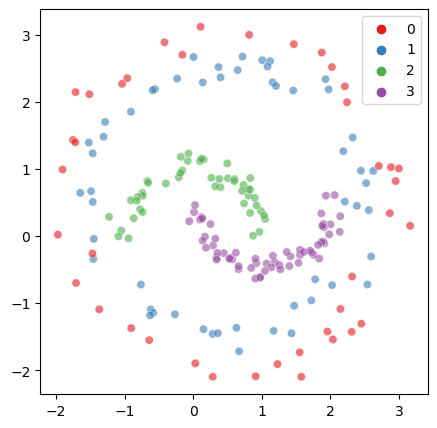

In [22]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    x=p_train[:, 0], y=p_train[:, 1], hue=l_train, palette=sns.color_palette("Set1"), alpha=0.6
)
plt.show()

In [23]:
gold_rbf = SVC(kernel="rbf", gamma=1.0, C=1.0)
gold_rbf.fit(p_train, l_train)
gold_preds = gold_rbf.predict(p_test)
gold_score = f1_score(gold_preds, l_test, average="macro"), accuracy_score(gold_preds, l_test)
print(gold_score)

(0.9206561159645665, 0.92)


In [24]:
my_rbf = NonlinearDualSVM(C=1.0, gamma=1.0)
my_rbf.fit(p_train, l_train)
preds = my_rbf.predict(p_test)
score = f1_score(preds, l_test, average="macro"), accuracy_score(preds, l_test)
print(score)

(0.9345303360744847, 0.935)


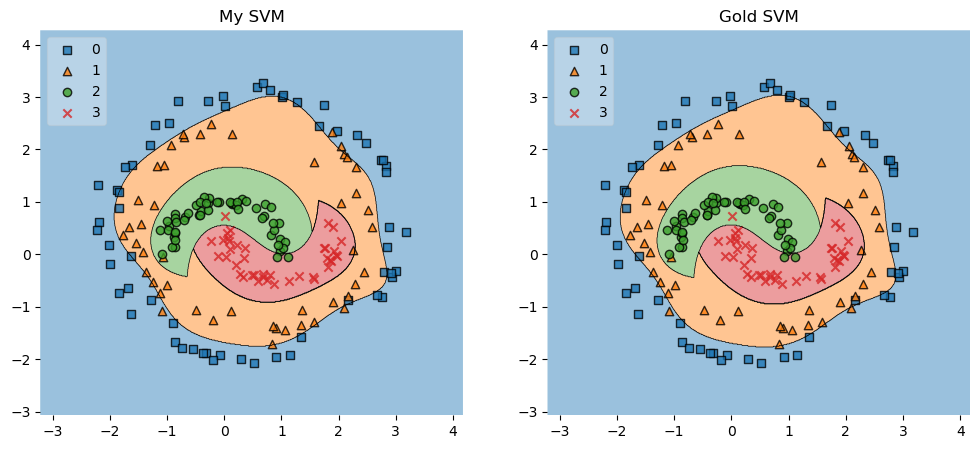

In [25]:
plot_difference(my_rbf, gold_rbf, X=p_test, y=l_test)